# Zadanie zrobione by: Adam A. Ignaciuk 

#############################################################################################

# Modern AI in Visual Computing 2025L - Assignment 1: CNN (20 points)

## Due date: 02.04.2025, 23:59

Any solution sent after the deadline will be penalized by lowering the maximum number of points by 10% for each started 24h period. The maximum possible delay is 7 days, after which the score is automatically 0 points (09.04.2025, 23:59).

## Authorship Policy

- Sharing knowledge and ideas with other students is encouraged.
- Sharing your code with others is not allowed.
- Using code from other students is not allowed.
- All submitted code must be your own original work.

## Task

In this task you will be training your own Convolutional Neural Network on the FashionMNIST dataset. The network is supposed to be able to recognize articles of clothing from their photos. The task is divided into 4 parts, each worth 5 points:

- **Part 1:** Loading and preparing the data needed to properly train and test the network.
- **Part 2:** Defining the Network class - creating the layers and implementing the forward pass.
- **Part 3:** Implementing the training loop.
- **Part 4:** Testing the accuracy of the resulting network.

Each part provides some starting code snippets. Make sure to use the variable names that are already proposed in them.

The task is heavily based on the Deep Lizard course, which you have been asked to go through during the lecture, so feel free to draw inspiration from the implementations provided there (https://www.youtube.com/playlist?list=PLtD9PVBm3mlrznSnuM2LoIEs_wjewo1gD).

## Part 0: Useful Imports

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from tqdm.auto import tqdm

#from torchsummary import summary

##Part 1: Load and Prepare the Data [5 pts]

In this task you will be working with the `FashionMNIST` dataset.

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

The dataset is part of the `torchvision.datasets` library and can be easilty accessed from there.

You task is to download both the training and test sets, transform the images to PyTorch tensors and perform normalization on both sets. Additionally split the training set into the proper training set and a validation set - 80% samples to the training set and 20% to the validation set.

After that you need to create a `DataLoader` for each of the three sets with a batch size od 1000.

In [ ]:
# Calculate mean and standard deviation for the train dataset

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1), (0.1)) 
                               ])

"""
tutaj miałem mały problem z tą normalizacją. Mimo, że tranformowałem tensory, niewiele to zmieniało, nie ważne od wartości zadanych w tranformatorze wyżej. Nie wpływa to bardzo na wyniki,
ale może wpłynąc na ich reprezentajcę. 
"""


trainset = torchvision.datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = torchvision.datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

mean = trainset.data.float().mean()
std = trainset.data.float().std()

print("Mean: ", trainset.data.float().mean(), "Standard deviation: ", trainset.data.float().std())

# Split the original training set into training and validation sets
train_set, validation_set = torch.utils.data.random_split(trainset, [int(len(trainset)*0.8), int(len(trainset)*0.2)])

#Create DataLoaders for the datasets
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 1000, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 1000, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size = 1000, shuffle = True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.55MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 18.4MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.14MB/s]

Mean:  tensor(72.9404) Standard deviation:  tensor(90.0212)


In [3]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

## Part 2: Define the Neural Network [5 pts]

Your task is to define the `Network` class, which should represent a convolutional neural network (CNN).  

A specific implementation is not enforced but must adhere to the following requirements:  

### Architecture  
1. **Three convolutional layers** with progressively increasing channel counts (e.g., 8 → 16 → 32).  
2. **Three linear (fully connected) layers** with progressively decreasing feature counts. The final layer must output 10 features (e.g., 128 → 64 → 10) to match the 10-class prediction task.  

### Forward Pass Steps  
1. Process all convolutional layers:  
   - Apply `ReLU` activation followed by max pooling after each convolutional layer.  
   - Max pooling should halve the spatial dimensions of the input (e.g., reduce image size by half).  
2. Flatten the output of the final convolutional layer into a 1D vector.  
3. Process all linear layers:  
   - Apply `ReLU` activation after each linear layer except the final one.

In [4]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


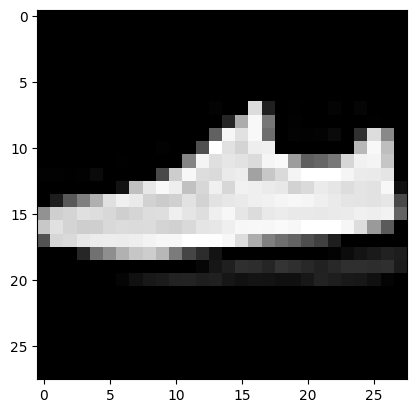

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    self.Flat = nn.Flatten()
    self.fc1 = nn.Linear(in_features=288, out_features=16)
    self.Dropout1 = nn.Dropout(0.25) #dodałem dropout, bo lepiej się uczy wtedy 
    self.fc2 = nn.Linear(in_features=16, out_features=8)
    self.fc3 = nn.Linear(in_features=8, out_features=10)

  def forward(self, t):
    t = self.layer1(t)
    t = self.layer2(t)
    t = self.layer3(t)
    t = self.Flat(t)
    t = self.fc1(t)
    t = F.relu(t)
    t = self.Dropout1(t)
    """
    Dodałem dropout bo wtedy lepiej mi się uczyło 
    """
    t = self.fc2(t)
    t = F.relu(t)
    t = self.fc3(t)
    return t

network = Network()
#summary(network, input_size=(1, 28, 28))



## Part 3: Train and Evaluate the Neural Network [5 pts]

Your task is to define the main training and evaluation loop.

1. Instantiate your network class and optimizer using the network's parameters (use the `Adam` optimizer).

2. Implement an epoch for both the training and validation phases. An epoch in this context means processing the entire dataset once:
  - For training: Compute the predictions, calculate the loss, count the number of accurate predictions, and perform the optimization step for each batch.
  - For validation: Do the same as training, but skip the optimization step.

3. At the end of each epoch, compute the four metrics listed, which are printed in the epoch summary.

**Note:** Use the `device` variable defined at the beginning to take advantage of the GPU if available.

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

network = Network()

train_losses = []
validation_losses = []

learning_rate = 0.002
optimizer = optim.Adam(network.parameters(), lr = learning_rate)

epochs = 15
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n")
    # Training phase
    network.train()
    total_train_loss = 0  # Sum of loss values from each batch
    total_train_correct = 0  # Sum of all correct prediction from each batch
    for batch in train_loader:

        images, labels = batch
        #images = images.to(device)
        #labels = labels.to(device)
        outputs = network(images)
        optimizer.zero_grad()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        total_train_correct += (outputs.argmax(dim=1) == labels).sum()
        train_losses.append(loss.item())


    # Validation phase
    network.eval()
    total_validation_loss = 0  # Sum of loss values from each batch
    total_validation_correct = 0  # Sum of all correct prediction from each batch
    with torch.no_grad():
        for batch in validation_loader:
            images, labels = batch
            #images = images.to(device)
            #labels = labels.to(device)
            outputs = network(images)
            loss = F.cross_entropy(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)

            total_validation_loss += loss.item()
            total_validation_correct += (predicted == labels).sum().item()

            validation_losses.append(loss.item())

    # Calculate epoch metrics
    train_average_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / len(trainset)
    validation_average_loss = total_validation_loss / len(validation_loader)
    validation_accuracy = total_validation_correct / len(validation_set)

    print(
        f'[Epoch {epoch:02d}] '
        f'Train Loss: {train_average_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, '
        f'Validation Loss: {validation_average_loss:.4f}, Validation Accuracy: {validation_accuracy * 100:.2f}%'
    )


Using device: cpu


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0

[Epoch 00] Train Loss: 1.6481, Train Accuracy: 30.78%, Validation Loss: 1.1843, Validation Accuracy: 59.82%
Epoch: 1

[Epoch 01] Train Loss: 0.9933, Train Accuracy: 52.09%, Validation Loss: 0.6342, Validation Accuracy: 79.66%
Epoch: 2

[Epoch 02] Train Loss: 0.6831, Train Accuracy: 60.97%, Validation Loss: 0.5008, Validation Accuracy: 83.03%
Epoch: 3

[Epoch 03] Train Loss: 0.5822, Train Accuracy: 63.90%, Validation Loss: 0.4591, Validation Accuracy: 84.13%
Epoch: 4

[Epoch 04] Train Loss: 0.5303, Train Accuracy: 65.28%, Validation Loss: 0.4324, Validation Accuracy: 85.14%
Epoch: 5

[Epoch 05] Train Loss: 0.4952, Train Accuracy: 66.42%, Validation Loss: 0.3907, Validation Accuracy: 86.71%
Epoch: 6

[Epoch 06] Train Loss: 0.4598, Train Accuracy: 67.44%, Validation Loss: 0.3742, Validation Accuracy: 87.30%
Epoch: 7

[Epoch 07] Train Loss: 0.4452, Train Accuracy: 67.85%, Validation Loss: 0.3607, Validation Accuracy: 87.67%
Epoch: 8

[Epoch 08] Train Loss: 0.4282, Train Accuracy:

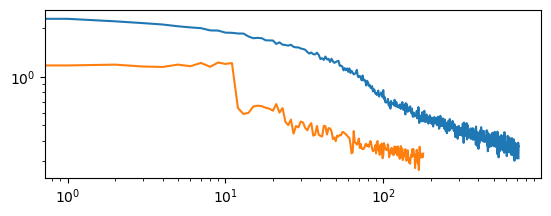

In [38]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
plt.plot(train_losses, label = "Training loss")
plt.plot(validation_losses, label = "Validation loss")
ax.set_yscale('log')
ax.set_xscale('log')


## Part 4: Test the Network [5 pts]

Your task is to test the performance of the trained network using the previously prepared test set.

To perform the evaluation of the network, perform the following steps:

1. **Calculate the Test Accuracy**
  - Compute all the network predictions for the test set.
  - Calculate how many of those predictions are correct.

2. **Calculate and Plot the Normalized Confusion Matrix**
  - Compute the normalized confusion matrix using the true labels and predictions (use the `sklearn.metrics.confusion_matrix` function).
  - Plot the matrix as a heatmap, similar to the example below.

<!-- ### Confusion Matrix Plot Example:
![](https://cdn.discordapp.com/attachments/811505842163286027/1351174301168046131/ge0Ix1yJ13EfwAAAABJRU5ErkJggg.png?ex=67d96aa1&is=67d81921&hm=46a5a3978ef8bff73be278b7ddd3697c687e58a19f08c3d1186b1e24abb7aa17&) -->

### Confusion Matrix Plot Example:

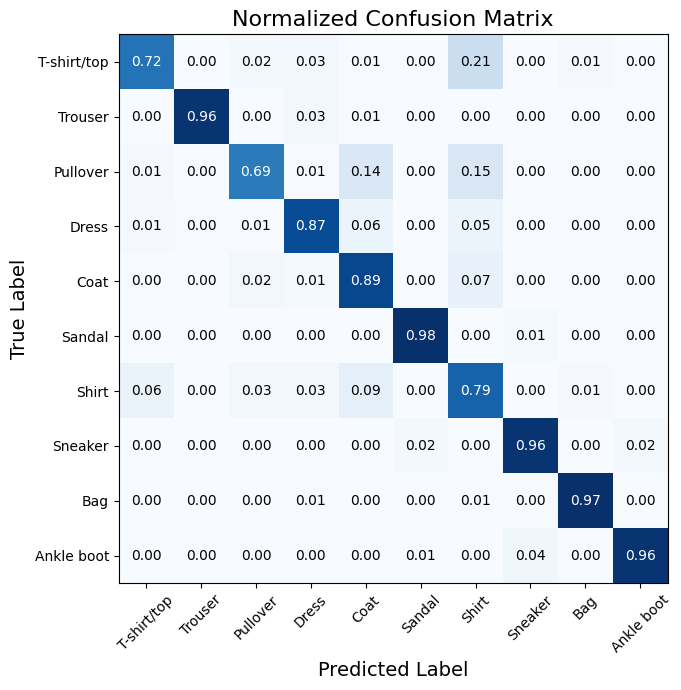

In [35]:
# Calculate test set accuracy
#all_predicitions = torch.tensor([]).to(device)
correct_predictions_count = 0
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        outputs = network(images)
        loss = F.cross_entropy(outputs, labels)
        correct_predictions_count += (outputs.argmax(dim=1) == labels).sum().item()


print(f'Test Accuracy: {correct_predictions_count}/{len(testset)} ({correct_predictions_count / len(testset) * 100:.2f}%)')

# Calculate normalized confusion matrix
normalized_confusion_matrix = confusion_matrix(outputs.argmax(dim=1), labels)
np.set_printoptions(precision=3, suppress = True, linewidth = np.inf)
print(f'Normalized Confustion Matrix:\n{normalized_confusion_matrix}')

# Plot the confusion matrix
class_names = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')

Test Accuracy: 8824/10000 (88.24%)
Normalized Confustion Matrix:
[[ 77   0   1   3   2   0  10   0   0   0]
 [  0 106   1   0   0   0   0   0   0   0]
 [  1   0  71   0   5   0   8   0   1   0]
 [  5   4   0  94   1   0   4   0   0   0]
 [  0   1  15   2  87   0  11   0   1   0]
 [  0   0   0   0   0  97   0   1   0   0]
 [ 21   1   7   4   5   0  70   0   0   0]
 [  0   0   0   0   0   3   0  89   0   0]
 [  1   0   0   1   1   0   0   1  85   0]
 [  0   0   0   0   0   0   0   8   0  94]]


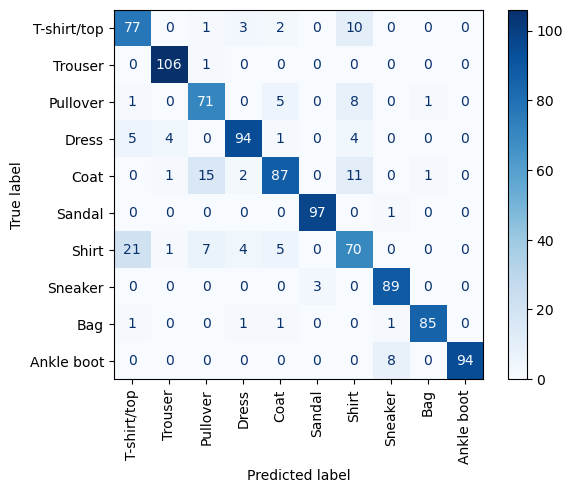

In [36]:
class_names = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=normalized_confusion_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()